In [1]:
# 1. Environment Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_ind, f_oneway
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
import os
import sys
import time

warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Plotting style
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Seed
np.random.seed(42)
torch.manual_seed(42)

print("Env ready")


Env ready


In [2]:
# 2. Load Dataset and Explore Basic Information
# Load dataset
data_path = '../data/emotion_dataset_20250830_213704.npz'
data = np.load(data_path, allow_pickle=True)

# Extract arrays
X_train = data['X_train']  # (n_trials, n_channels, n_samples)
X_val   = data['X_val']
X_test  = data['X_test']
y_train = data['y_train']
y_val   = data['y_val']
y_test  = data['y_test']

# Metadata
sampling_rate = int(data['sampling_rate'])
channel_names = data['channel_names'].tolist()
class_names   = data['class_names'].tolist()
label_map     = data['label_map'].item() if hasattr(data['label_map'], 'item') else data['label_map']

print("Dataset loaded")
print(f"Shapes | X_train{X_train.shape}  X_val{X_val.shape}  X_test{X_test.shape}")
print(f"Meta   | fs={sampling_rate}Hz  ch={len(channel_names)}  classes={class_names}")


Dataset loaded
Shapes | X_train(42, 6, 2500)  X_val(9, 6, 2500)  X_test(9, 6, 2500)
Meta   | fs=250Hz  ch=6  classes=['negative', 'neutral', 'positive']


In [3]:
# 3. Data Preprocessing and Feature Extraction
from utils.preprocess import preprocess_batch
from utils.features import extract_features

# Preprocess
X_train_preprocessed = preprocess_batch(
    X_train, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
X_val_preprocessed = preprocess_batch(
    X_val, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
X_test_preprocessed = preprocess_batch(
    X_test, fs=sampling_rate, notch_freq=50, band=(1.0, 40.0), order=4, do_zscore=True
)
print("Preprocess: notch/bandpass/z-score done")

# Windowing
window_size = int(2.0 * sampling_rate)
hop_size    = int(1.0 * sampling_rate)

def segment_data(data, window_size, hop_size):
    # Segment trials into overlapping windows
    n_trials, n_channels, n_samples = data.shape
    windows = []
    for trial_idx in range(n_trials):
        trial = data[trial_idx]
        for start in range(0, n_samples - window_size + 1, hop_size):
            window = trial[:, start:start + window_size]
            windows.append(window)
    return np.array(windows)

X_train_windowed = segment_data(X_train_preprocessed, window_size, hop_size)
X_val_windowed   = segment_data(X_val_preprocessed, window_size, hop_size)
X_test_windowed  = segment_data(X_test_preprocessed, window_size, hop_size)

n_windows_per_trial = len(range(0, X_train.shape[-1] - window_size + 1, hop_size))
y_train_windowed = np.repeat(y_train, n_windows_per_trial)
y_val_windowed   = np.repeat(y_val,   n_windows_per_trial)
y_test_windowed  = np.repeat(y_test,  n_windows_per_trial)

print(f"Windowing: size={window_size} hop={hop_size} -> "
      f"Train{X_train_windowed.shape[0]}, Val{X_val_windowed.shape[0]}, Test{X_test_windowed.shape[0]}")

# Feature extraction
features = extract_features(
    X_train_windowed, X_val_windowed, X_test_windowed,
    fs=sampling_rate,
    bands=((4, 8), (8, 13), (13, 30)),
    make_images = True,
    channel_method='average'
)

X_time_train = features['X_time_train']
X_freq_train = features['X_freq_train']
X_time_val   = features['X_time_val']
X_freq_val   = features['X_freq_val']
X_time_test  = features['X_time_test']
X_freq_test  = features['X_freq_test']
X_img_train = features['X_img_train']
X_img_val   = features['X_img_val']
X_img_test  = features['X_img_test']
# Update labels
y_train = y_train_windowed
y_val   = y_val_windowed
y_test  = y_test_windowed

print("Feature extraction: time+bandpower done")
print(f"Features | time_train{X_time_train.shape}  freq_train{X_freq_train.shape}")

Preprocess: notch/bandpass/z-score done
Windowing: size=500 hop=250 -> Train378, Val81, Test81
Feature extraction: time+bandpower done
Features | time_train(378, 6, 500)  freq_train(378, 6, 3)


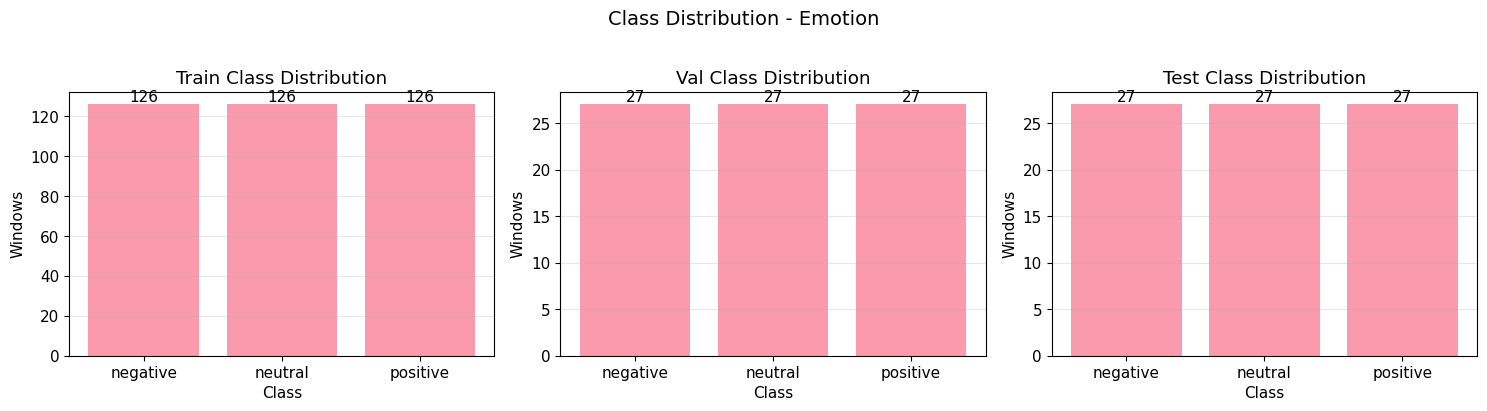

Class balance (%):
  Train negative:33.3%, neutral:33.3%, positive:33.3%
  Val   negative:33.3%, neutral:33.3%, positive:33.3%
  Test  negative:33.3%, neutral:33.3%, positive:33.3%


In [4]:
# 4. Class Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (y_data, title) in enumerate([(y_train, 'Train'), (y_val, 'Val'), (y_test, 'Test')]):
    unique, counts = np.unique(y_data, return_counts=True)
    axes[idx].bar([class_names[i] for i in unique], counts, alpha=0.7)
    axes[idx].set_title(f'{title} Class Distribution')
    axes[idx].set_xlabel('Class'); axes[idx].set_ylabel('Windows')
    axes[idx].grid(axis='y', alpha=0.3)
    for i, (u, c) in enumerate(zip(unique, counts)):
        axes[idx].text(i, c, str(c), ha='center', va='bottom')
plt.suptitle('Class Distribution - Emotion', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

print("Class balance (%):")
for name, y_data in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    unique, counts = np.unique(y_data, return_counts=True)
    pct = (counts / counts.sum() * 100).round(1)
    pairs = ", ".join([f"{class_names[u]}:{p}%" for u, p in zip(unique, pct)])
    print(f"  {name:<5} {pairs}")


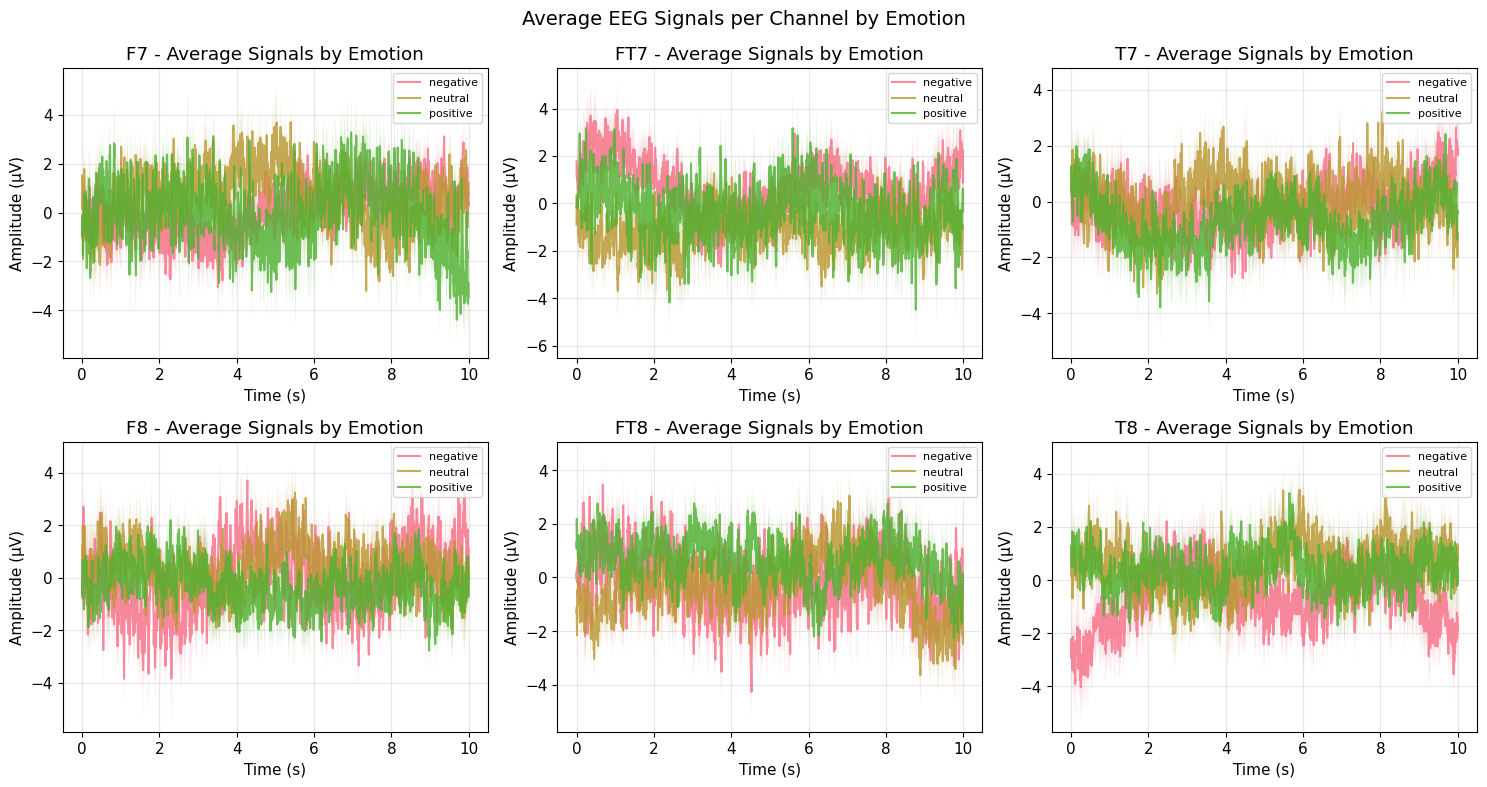


Channel stats (Train):
Channel    Mean±SD (μV)         Min          Max          SNR(dB)   
F7            0.21±4.60         -19.22       20.51      0.01
FT7          -0.24±4.58         -19.92       19.81      0.01
T7           -0.27±4.22         -15.77       21.08      0.02
F8            0.02±4.40         -20.45       18.65      0.00
FT8           0.04±4.44         -20.16       19.13      0.00
T8            0.09±4.40         -17.06       16.84      0.00


In [5]:
# 5. Signal Quality Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ch_idx, ch_name in enumerate(channel_names):
    ax = axes[ch_idx // 3, ch_idx % 3]
    for class_idx, class_name in enumerate(class_names):
        class_mask    = data['y_train'] == class_idx
        class_signals = data['X_train'][class_mask, ch_idx, :]
        mean_signal   = np.mean(class_signals, axis=0)
        std_signal    = np.std(class_signals, axis=0) / np.sqrt(len(class_signals))
        time_axis     = np.arange(len(mean_signal)) / sampling_rate
        ax.plot(time_axis, mean_signal, label=class_name, alpha=0.8)
        ax.fill_between(time_axis, mean_signal - std_signal, mean_signal + std_signal, alpha=0.2)
    ax.set_title(f'{ch_name} - Average Signals by Emotion')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Amplitude (μV)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
plt.suptitle('Average EEG Signals per Channel by Emotion', fontsize=14)
plt.tight_layout(); plt.show()

print("\nChannel stats (Train):")
print(f"{'Channel':<10} {'Mean±SD (μV)':<20} {'Min':<12} {'Max':<12} {'SNR(dB)':<10}")
for ch_idx, ch_name in enumerate(channel_names):
    ch_data   = data['X_train'][:, ch_idx, :].flatten()
    mean_val  = np.mean(ch_data)
    std_val   = np.std(ch_data)
    min_val   = np.min(ch_data)
    max_val   = np.max(ch_data)
    signal_p  = np.mean(ch_data**2)
    noise_p   = np.var(ch_data)
    snr       = 10 * np.log10(signal_p / noise_p) if noise_p > 0 else 0
    print(f"{ch_name:<10} {mean_val:>7.2f}±{std_val:<7.2f} {min_val:>11.2f} {max_val:>11.2f} {snr:>9.2f}")


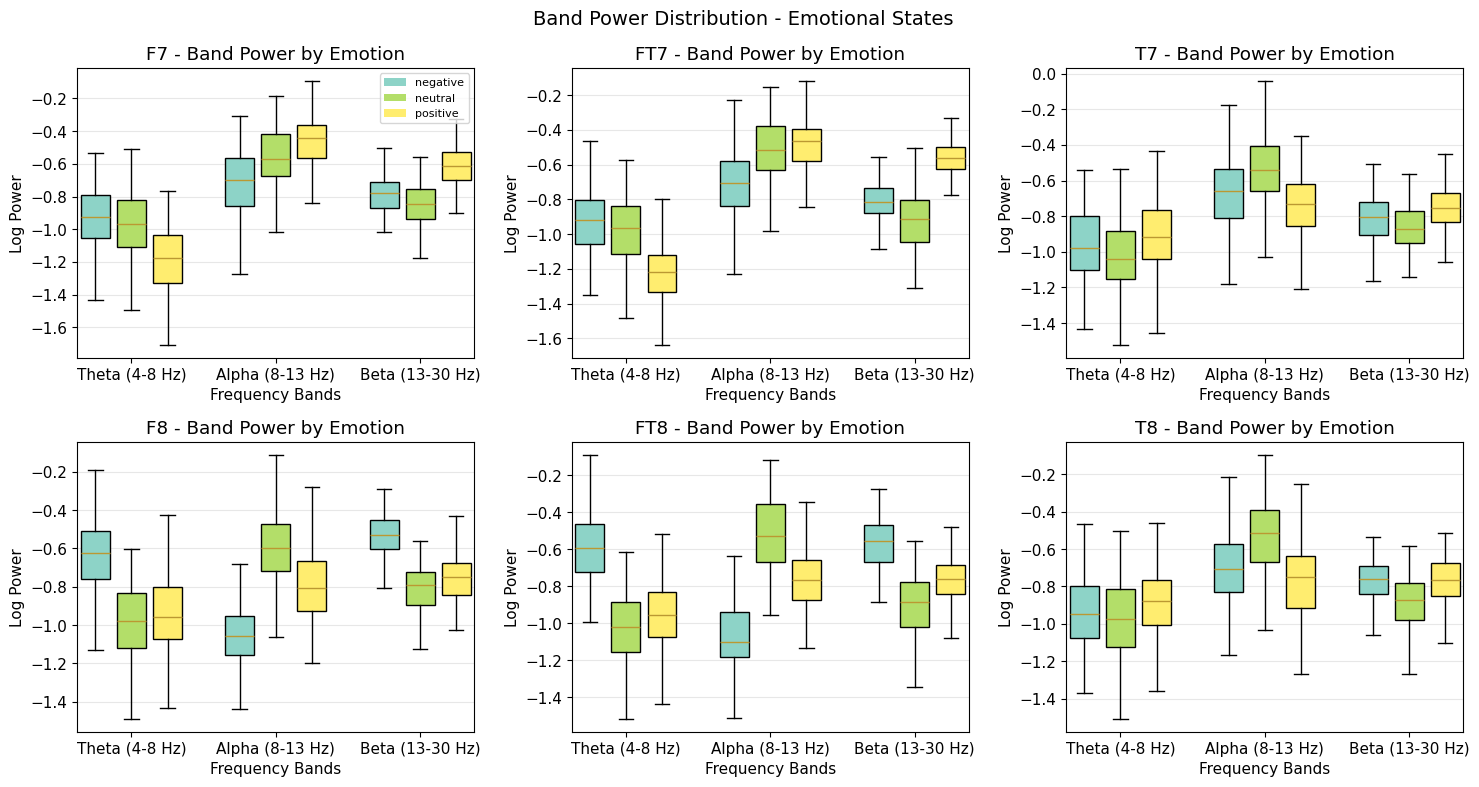


Band-power ANOVA p-values (p<0.05 indicates significance)
Channel    Theta           Alpha           Beta           
F7         0.0000          0.0000          0.0000         
FT7        0.0000          0.0000          0.0000         
T7         0.0002          0.0000          0.0000         
F8         0.0000          0.0000          0.0000         
FT8        0.0000          0.0000          0.0000         
T8         0.1118          0.0000          0.0000         


In [6]:
# 6. Frequency Domain Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
band_names = ['Theta (4-8 Hz)', 'Alpha (8-13 Hz)', 'Beta (13-30 Hz)']
for ch_idx, ch_name in enumerate(channel_names):
    ax = axes[ch_idx // 3, ch_idx % 3]
    band_powers = []
    for class_idx in range(len(class_names)):
        class_mask = y_train == class_idx
        class_freq = X_freq_train[class_mask, ch_idx, :]
        band_powers.append(class_freq)
    for band_idx in range(3):
        band_positions = [band_idx * 4 + i for i in range(len(class_names))]
        band_data = [band_powers[i][:, band_idx] for i in range(len(class_names))]
        bp = ax.boxplot(band_data, positions=band_positions, widths=0.8,
                        patch_artist=True, showfliers=False)
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
    ax.set_title(f'{ch_name} - Band Power by Emotion')
    ax.set_xlabel('Frequency Bands'); ax.set_ylabel('Log Power')
    ax.set_xticks([1, 5, 9]); ax.set_xticklabels(band_names)
    ax.grid(True, alpha=0.3, axis='y')
    if ch_idx == 0:
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.Set3(i/2), label=class_names[i]) 
                           for i in range(len(class_names))]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
plt.suptitle('Band Power Distribution - Emotional States', fontsize=14)
plt.tight_layout(); plt.show()

print("\nBand-power ANOVA p-values (p<0.05 indicates significance)")
print(f"{'Channel':<10} {'Theta':<15} {'Alpha':<15} {'Beta':<15}")
for ch_idx, ch_name in enumerate(channel_names):
    p_values = []
    for band_idx in range(3):
        groups = [X_freq_train[y_train == i, ch_idx, band_idx] for i in range(len(class_names))]
        _, p_val = f_oneway(*groups)
        p_values.append(p_val)
    print(f"{ch_name:<10} {p_values[0]:<15.4f} {p_values[1]:<15.4f} {p_values[2]:<15.4f}")


PCA/t-SNE running ...


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\gansh\.conda\envs\torch_gpu\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


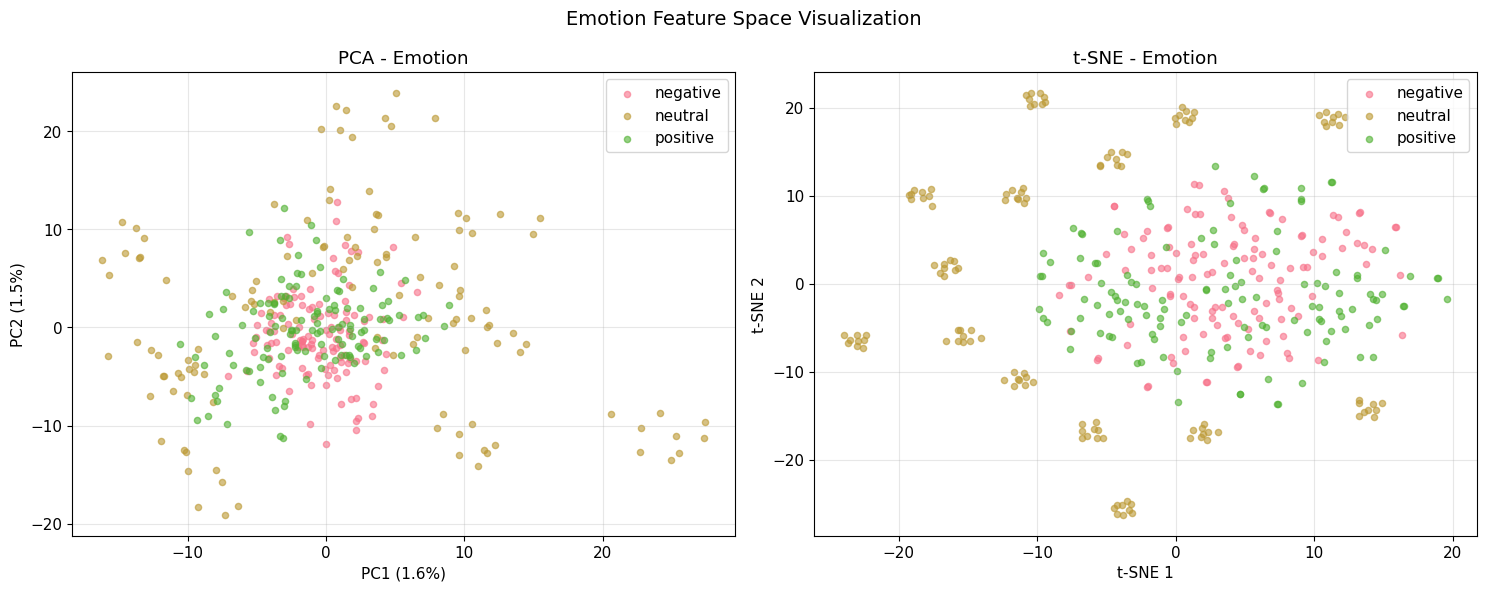

PCA: 10 comps=12.8%, 50 comps=41.5%, 90% at 1 comps


In [7]:
# 7. Feature Visualization (PCA & t-SNE)
X_combined_train = np.concatenate([
    X_time_train.reshape(X_time_train.shape[0], -1),
    X_freq_train.reshape(X_freq_train.shape[0], -1)
], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_train)

print("PCA/t-SNE running ...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

n_samples_tsne = min(1000, len(X_scaled))
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca[:n_samples_tsne])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
for class_idx, class_name in enumerate(class_names):
    mask = y_train[:len(X_pca)] == class_idx
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=class_name, alpha=0.6, s=20)
ax.set_title('PCA - Emotion'); ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)'); ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
for class_idx, class_name in enumerate(class_names):
    mask = y_train[:n_samples_tsne] == class_idx
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=class_name, alpha=0.6, s=20)
ax.set_title('t-SNE - Emotion'); ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle('Emotion Feature Space Visualization', fontsize=14)
plt.tight_layout(); plt.show()

cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"PCA: 10 comps={cumsum_var[9]*100:.1f}%, 50 comps={cumsum_var[49]*100:.1f}%, 90% at {n_components_90} comps")


Testing Time-only model...
  Time-only val acc: 0.4321
Testing Freq-only model...
  Freq-only val acc: 0.7654
Testing Img-only model...
  Img-only val acc: 0.5926
Testing MultiModal...
  MultiModal val acc: 0.6790

*** Best model: Freq with val acc: 0.7654 ***


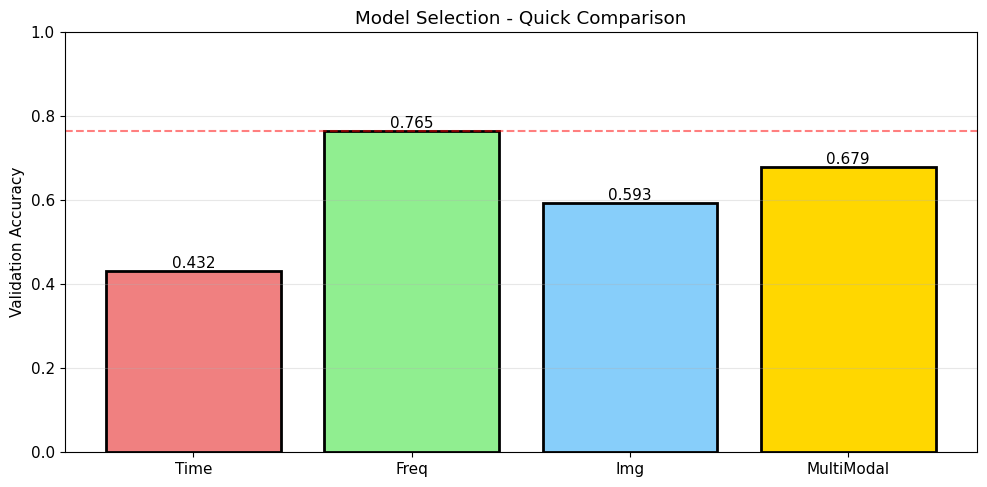

In [8]:
# 8. Model Selection (Quick Comparison)
from models.branches import TimeBranch, FreqBranch, ImgBranch
from collections import Counter

n_channels = 6
n_samples  = window_size
n_bands    = 3
hidden_dim = 64
img_out_dim= 64
n_classes  = len(class_names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Prepare datasets
train_dataset = TensorDataset(
    torch.FloatTensor(X_time_train),
    torch.FloatTensor(X_freq_train),
    torch.FloatTensor(X_img_train),        
    torch.LongTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_time_val),
    torch.FloatTensor(X_freq_val),
    torch.FloatTensor(X_img_val),     
    torch.LongTensor(y_val)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# Class weights
cnt = Counter(y_train.tolist())
cls_w = torch.tensor([1.0 / max(cnt.get(i, 1), 1) for i in range(len(class_names))],
                     dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=cls_w, label_smoothing=0.1)

# Quick model comparison
class TimeOnlyModel(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.time_branch = TimeBranch(n_channels, n_samples, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x_time):
        feats = self.time_branch(x_time)
        return self.fc(feats)

class FreqOnlyModel(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.freq_branch = FreqBranch(n_channels, n_bands, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x_freq):
        feats = self.freq_branch(x_freq)
        return self.fc(feats)

class ImgOnlyModel(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.img_branch = ImgBranch(img_out_dim)
        self.fc = nn.Linear(img_out_dim, n_classes)
    def forward(self, x_img):
        feats = self.img_branch(x_img)
        return self.fc(feats)

def quick_train(model, data_idx, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            x = batch[data_idx].to(device)
            y = batch[3].to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[data_idx].to(device)
            y = batch[3].to(device)
            outputs = model(x)
            _, pred = outputs.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
    return correct / total

model_scores = {}

# Test Time-only
print("Testing Time-only model...")
time_model = TimeOnlyModel(n_classes).to(device)
model_scores['Time'] = quick_train(time_model, 0)
print(f"  Time-only val acc: {model_scores['Time']:.4f}")

# Test Freq-only
print("Testing Freq-only model...")
freq_model = FreqOnlyModel(n_classes).to(device)
model_scores['Freq'] = quick_train(freq_model, 1)
print(f"  Freq-only val acc: {model_scores['Freq']:.4f}")

# Test Img-only
print("Testing Img-only model...")
img_model = ImgOnlyModel(n_classes).to(device)
model_scores['Img'] = quick_train(img_model, 2)
print(f"  Img-only val acc: {model_scores['Img']:.4f}")

# Test MultiModal
print("Testing MultiModal...")
from models.multimodal_model import MultiModalNet
multi_model = MultiModalNet(
    n_channels=n_channels, n_samples=n_samples, n_bands=n_bands,
    img_out_dim=img_out_dim, hidden_dim=hidden_dim, n_classes=n_classes, use_img=True
).to(device)
optimizer = optim.Adam(multi_model.parameters(), lr=1e-3)
multi_model.train()
for epoch in range(10):
    for x_time, x_freq, x_img, y in train_loader:
        x_time, x_freq, x_img, y = x_time.to(device), x_freq.to(device), x_img.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = multi_model(x_time, x_freq, x_img)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
multi_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x_time, x_freq, x_img, y in val_loader:
        x_time, x_freq, x_img, y = x_time.to(device), x_freq.to(device), x_img.to(device), y.to(device)
        outputs = multi_model(x_time, x_freq, x_img)
        _, pred = outputs.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
model_scores['MultiModal'] = correct / total
print(f"  MultiModal val acc: {model_scores['MultiModal']:.4f}")

# Determine best model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n*** Best model: {best_model_name} with val acc: {model_scores[best_model_name]:.4f} ***")

# Plot comparison
plt.figure(figsize=(10, 5))
models = list(model_scores.keys())
scores = list(model_scores.values())
colors = ['lightcoral', 'lightgreen', 'lightskyblue', 'gold']
bars = plt.bar(models, scores, color=colors, edgecolor='black', linewidth=2)
plt.ylabel('Validation Accuracy'); plt.title('Model Selection - Quick Comparison')
plt.ylim([0, 1]); plt.grid(True, alpha=0.3, axis='y')
for bar, score in zip(bars, scores):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h, f'{score:.3f}', ha='center', va='bottom')
plt.axhline(y=max(scores), color='r', linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()


Device: cuda
Params: total=2,531 trainable=2,531
Training ...
Epoch 10/50 | Train 1.0885/0.6614 | Val 1.0864/0.6173
Epoch 20/50 | Train 1.0652/0.6746 | Val 1.0669/0.6790
Epoch 30/50 | Train 1.0097/0.6931 | Val 1.0028/0.7037
Epoch 40/50 | Train 0.9146/0.7143 | Val 0.9011/0.7037
Epoch 50/50 | Train 0.8258/0.7275 | Val 0.8064/0.7407


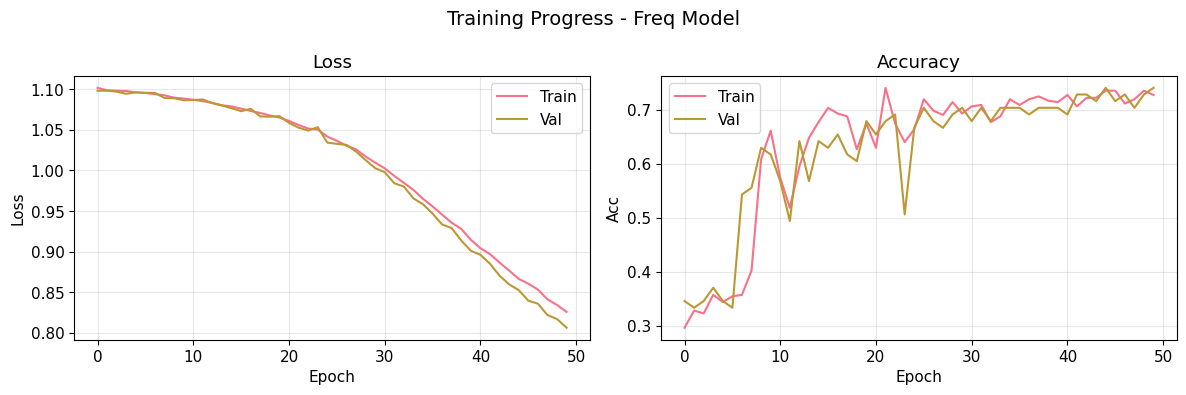

Train done
Best val acc: 0.7407 @ epoch 45
Model saved: ../best_emotion_freq_model.pth


In [9]:
# 9. Full Training with Best Model
# Select and create the best model
if best_model_name == 'Time':
    model = TimeOnlyModel(n_classes).to(device)
    def get_batch_data(batch):
        return batch[0], batch[3]  # x_time, y
elif best_model_name == 'Freq':
    model = FreqOnlyModel(n_classes).to(device)
    def get_batch_data(batch):
        return batch[1], batch[3]  # x_freq, y
elif best_model_name == 'Img':
    model = ImgOnlyModel(n_classes).to(device)
    def get_batch_data(batch):
        return batch[2], batch[3]  # x_img, y
else:  # MultiModal
    model = MultiModalNet(
        n_channels=n_channels, n_samples=n_samples, n_bands=n_bands,
        img_out_dim=img_out_dim, hidden_dim=hidden_dim, n_classes=n_classes, use_img=True
    ).to(device)
    def get_batch_data(batch):
        return (batch[0], batch[1], batch[2]), batch[3]  # (x_time, x_freq, x_img), y

# Full training setup
test_dataset = TensorDataset(
    torch.FloatTensor(X_time_test),
    torch.FloatTensor(X_freq_test),
    torch.FloatTensor(X_img_test),    
    torch.LongTensor(y_test)
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f"Device: {device}")
print(f"Params: total={sum(p.numel() for p in model.parameters()):,} "
      f"trainable={sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch in loader:
        x_data, y = get_batch_data(batch)
        
        if isinstance(x_data, tuple):  # MultiModal
            x_data = [d.to(device, non_blocking=True) for d in x_data]
            outputs = model(*x_data)
        else:  # Single modal
            x_data = x_data.to(device, non_blocking=True)
            outputs = model(x_data)
        
        y = y.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in loader:
            x_data, y = get_batch_data(batch)
            
            if isinstance(x_data, tuple):  # MultiModal
                x_data = [d.to(device, non_blocking=True) for d in x_data]
                outputs = model(*x_data)
            else:  # Single modal
                x_data = x_data.to(device, non_blocking=True)
                outputs = model(x_data)
            
            y = y.to(device, non_blocking=True)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
    return total_loss / len(loader), correct / total

# Full training
epochs = 50
train_losses, train_accs, val_losses, val_accs = [], [], [], []

print("Training ...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss);     val_accs.append(val_acc)
    scheduler.step(val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:02d}/{epochs} | Train {train_loss:.4f}/{train_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train'); axes[0].plot(val_losses, label='Val')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(train_accs, label='Train'); axes[1].plot(val_accs, label='Val')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Acc');  axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.suptitle(f'Training Progress - {best_model_name} Model', fontsize=14); plt.tight_layout(); plt.show()

print("Train done")
print(f"Best val acc: {max(val_accs):.4f} @ epoch {np.argmax(val_accs)+1}")

model_save_path = f'../best_emotion_{best_model_name.lower()}_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved: {model_save_path}")

Test | loss=0.9032 acc=0.6790


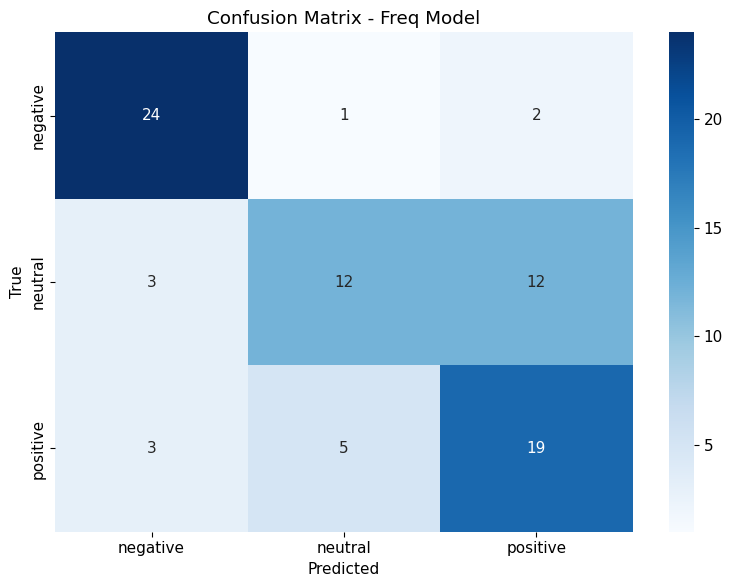


Classification report:
              precision    recall  f1-score   support

    negative     0.8000    0.8889    0.8421        27
     neutral     0.6667    0.4444    0.5333        27
    positive     0.5758    0.7037    0.6333        27

    accuracy                         0.6790        81
   macro avg     0.6808    0.6790    0.6696        81
weighted avg     0.6808    0.6790    0.6696        81



In [10]:
# 10. Model Evaluation
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test | loss={test_loss:.4f} acc={test_acc:.4f}")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        x_data, y = get_batch_data(batch)
        
        if isinstance(x_data, tuple):  # MultiModal
            x_data = [d.to(device) for d in x_data]
            outputs = model(*x_data)
        else:  # Single modal
            x_data = x_data.to(device)
            outputs = model(x_data)
        
        _, pred = outputs.max(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(f'Confusion Matrix - {best_model_name} Model')
plt.tight_layout(); plt.show()

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


In [11]:
# 11. Extra metrics
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score

N = len(class_names)
y_true = all_labels
y_pred = all_preds

# macro-F1
macro_f1 = f1_score(y_true, y_pred, average='macro',
                    labels=list(range(N)), zero_division=0)

# Cohen's kappa
kappa = cohen_kappa_score(y_true, y_pred, labels=list(range(N)))

# balanced accuracy
bacc = balanced_accuracy_score(y_true, y_pred)

# ITR (bits/trial & bits/min)
def itr_bits_per_trial(N, P):
    eps = 1e-12
    P = np.clip(P, eps, 1 - eps)
    return np.log2(N) + P*np.log2(P) + (1-P)*np.log2((1-P)/(N-1))

P_acc = accuracy_score(y_true, y_pred)
T_decision = hop_size / sampling_rate    # seconds per decision

itr_bpt = itr_bits_per_trial(N, P_acc)
itr_bpm = itr_bpt * 60.0 / T_decision

print(f"Extra metrics | acc={P_acc:.4f}  macro-F1={macro_f1:.4f}  kappa={kappa:.4f}  "
      f"bAcc={bacc:.4f}  ITR={itr_bpt:.3f} bits/trial, {itr_bpm:.1f} bits/min (T={T_decision:.1f}s)")


Extra metrics | acc=0.6790  macro-F1=0.6696  kappa=0.5185  bAcc=0.6790  ITR=0.359 bits/trial, 21.5 bits/min (T=1.0s)


Analyzing frequency domain importance...


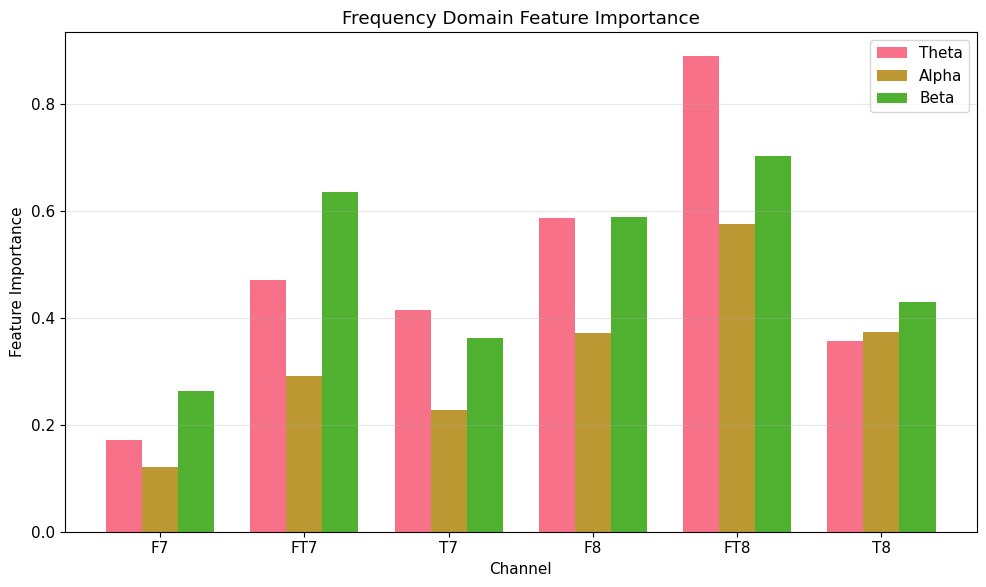

In [12]:
# 12. Feature Importance Analysis
if best_model_name == 'Time' or (best_model_name == 'MultiModal'):
    print("Analyzing time domain importance...")
    model.train()
    feature_importance_time = np.zeros((6, X_time_test.shape[-1]))
    correct_mask = all_preds == all_labels
    correct_indices = np.where(correct_mask)[0][:min(50, correct_mask.sum())]
    
    for idx in correct_indices:
        if best_model_name == 'Time':
            x = torch.FloatTensor(X_time_test[idx:idx+1]).to(device).requires_grad_(True)
            output = model(x)
        else:  # MultiModal
            x_time = torch.FloatTensor(X_time_test[idx:idx+1]).to(device).requires_grad_(True)
            x_freq = torch.FloatTensor(X_freq_test[idx:idx+1]).to(device)
            x_img = torch.FloatTensor(X_img_test[idx:idx+1]).to(device)
            output = model(x_time, x_freq, x_img)
            x = x_time
        output[0, all_labels[idx]].backward()
        feature_importance_time += np.abs(x.grad.cpu().numpy()[0])
    
    feature_importance_time /= len(correct_indices)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    time_axis = np.arange(X_time_test.shape[-1]) / sampling_rate
    for ch_idx, ch_name in enumerate(channel_names):
        ax = axes[ch_idx // 3, ch_idx % 3]
        ax.plot(time_axis, feature_importance_time[ch_idx], linewidth=1.5)
        ax.set_title(f'{ch_name} - Time Importance')
        ax.set_xlabel('Time (s)'); ax.set_ylabel('Importance')
        ax.grid(True, alpha=0.3)
        ax.fill_between(time_axis, 0, feature_importance_time[ch_idx], alpha=0.3)
    plt.suptitle('Time Domain Feature Importance', fontsize=14)
    plt.tight_layout(); plt.show()

if best_model_name == 'Freq' or (best_model_name == 'MultiModal'):
    print("Analyzing frequency domain importance...")
    model.train()
    feature_importance_freq = np.zeros((6, 3))
    correct_mask = all_preds == all_labels
    correct_indices = np.where(correct_mask)[0][:min(50, correct_mask.sum())]
    
    for idx in correct_indices:
        if best_model_name == 'Freq':
            x = torch.FloatTensor(X_freq_test[idx:idx+1]).to(device).requires_grad_(True)
            output = model(x)
        else:  # MultiModal
            x_time = torch.FloatTensor(X_time_test[idx:idx+1]).to(device)
            x_freq = torch.FloatTensor(X_freq_test[idx:idx+1]).to(device).requires_grad_(True)
            x_img = torch.FloatTensor(X_img_test[idx:idx+1]).to(device)
            output = model(x_time, x_freq, x_img)
            x = x_freq
        output[0, all_labels[idx]].backward()
        feature_importance_freq += np.abs(x.grad.cpu().numpy()[0])
    
    feature_importance_freq /= len(correct_indices)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x_pos = np.arange(len(channel_names)); width = 0.25
    for band_idx, band_name in enumerate(['Theta', 'Alpha', 'Beta']):
        values = feature_importance_freq[:, band_idx]
        ax.bar(x_pos + band_idx * width, values, width, label=band_name)
    ax.set_xlabel('Channel'); ax.set_ylabel('Feature Importance')
    ax.set_title('Frequency Domain Feature Importance')
    ax.set_xticks(x_pos + width); ax.set_xticklabels(channel_names)
    ax.legend(); ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout(); plt.show()

if best_model_name == 'Img':
    print("Image-based model: Feature importance via occlusion analysis...")
    # Simple occlusion-based importance for image features
    model.eval()
    baseline_acc = test_acc
    occlusion_scores = np.zeros((X_img_test.shape[2], X_img_test.shape[3]))
    
    with torch.no_grad():
        for i in range(0, X_img_test.shape[2], 4):  # Step through image
            for j in range(0, X_img_test.shape[3], 4):
                # Create occluded version
                X_img_occluded = X_img_test.copy()
                X_img_occluded[:, :, i:min(i+4, X_img_test.shape[2]), 
                               j:min(j+4, X_img_test.shape[3])] = 0
                
                # Test with occlusion
                correct = 0
                for k in range(0, len(X_img_occluded), batch_size):
                    batch = torch.FloatTensor(X_img_occluded[k:k+batch_size]).to(device)
                    pred = model(batch).argmax(1)
                    correct += (pred.cpu().numpy() == y_test[k:k+batch_size]).sum()
                
                acc_occluded = correct / len(y_test)
                importance = baseline_acc - acc_occluded
                occlusion_scores[i:min(i+4, X_img_test.shape[2]), 
                                j:min(j+4, X_img_test.shape[3])] = importance
    
    plt.figure(figsize=(10, 8))
    plt.imshow(occlusion_scores, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Importance')
    plt.title('Spectrogram Region Importance (via Occlusion)')
    plt.xlabel('Time'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()


RT perf:
  infer=0.16±0.39 ms (min=0.00, max=1.41) | rate≈6125.3 Hz | win=2.0s | RTF=12250.6x


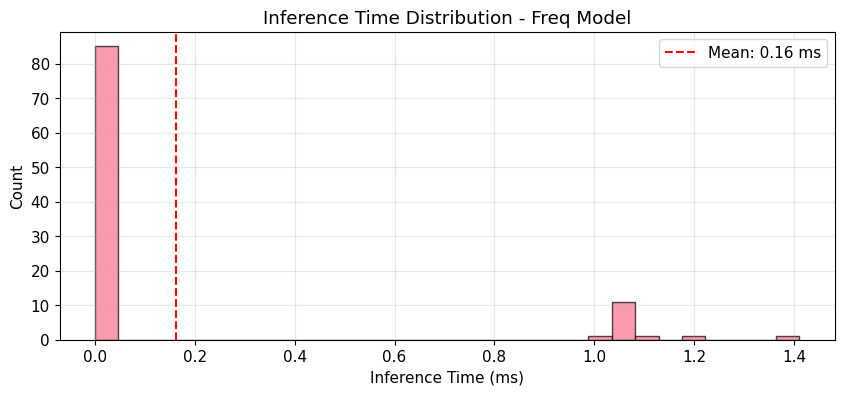

In [13]:
# 13. Real-time Performance Evaluation
model.eval()
inference_times = []

# Prepare single sample based on model type
if best_model_name == 'Time':
    sample_data = torch.FloatTensor(X_time_test[0:1]).to(device)
elif best_model_name == 'Freq':
    sample_data = torch.FloatTensor(X_freq_test[0:1]).to(device)
elif best_model_name == 'Img':
    sample_data = torch.FloatTensor(X_img_test[0:1]).to(device)
else:  # MultiModal
    sample_data = (torch.FloatTensor(X_time_test[0:1]).to(device),
                   torch.FloatTensor(X_freq_test[0:1]).to(device),
                   torch.FloatTensor(X_img_test[0:1]).to(device))

with torch.no_grad():
    for _ in range(100):
        t0 = time.time()
        if isinstance(sample_data, tuple):
            _ = model(*sample_data)
        else:
            _ = model(sample_data)
        inference_times.append((time.time() - t0) * 1000)

avg_infer = np.mean(inference_times); std_infer = np.std(inference_times)
print("RT perf:")
print(f"  infer={avg_infer:.2f}±{std_infer:.2f} ms "
      f"(min={np.min(inference_times):.2f}, max={np.max(inference_times):.2f}) | "
      f"rate≈{1000/avg_infer:.1f} Hz | "
      f"win={window_size/sampling_rate:.1f}s | "
      f"RTF={(window_size/sampling_rate*1000)/avg_infer:.1f}x")

plt.figure(figsize=(10, 4))
plt.hist(inference_times, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(avg_infer, color='red', linestyle='--', label=f'Mean: {avg_infer:.2f} ms')
plt.xlabel('Inference Time (ms)'); plt.ylabel('Count')
plt.title(f'Inference Time Distribution - {best_model_name} Model')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

In [14]:
# 14. Cross-validation Analysis
from sklearn.model_selection import KFold

print("\n=== CROSS-VALIDATION ===")
X_time_all = np.concatenate([X_time_train, X_time_val, X_time_test])
X_freq_all = np.concatenate([X_freq_train, X_freq_val, X_freq_test])
X_img_all = np.concatenate([X_img_train, X_img_val, X_img_test])
y_all = np.concatenate([y_train, y_val, y_test])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

print(f"CV (5-fold) with {best_model_name} model...")
for fold, (tr_idx, te_idx) in enumerate(kf.split(X_time_all), 1):
    # Create model based on best model type
    if best_model_name == 'Time':
        cv_model = TimeOnlyModel(n_classes).to(device)
        cv_train_ds = TensorDataset(torch.FloatTensor(X_time_all[tr_idx]),
                                    torch.LongTensor(y_all[tr_idx]))
        cv_test_ds = TensorDataset(torch.FloatTensor(X_time_all[te_idx]),
                                   torch.LongTensor(y_all[te_idx]))
    elif best_model_name == 'Freq':
        cv_model = FreqOnlyModel(n_classes).to(device)
        cv_train_ds = TensorDataset(torch.FloatTensor(X_freq_all[tr_idx]),
                                    torch.LongTensor(y_all[tr_idx]))
        cv_test_ds = TensorDataset(torch.FloatTensor(X_freq_all[te_idx]),
                                   torch.LongTensor(y_all[te_idx]))
    elif best_model_name == 'Img':
        cv_model = ImgOnlyModel(n_classes).to(device)
        cv_train_ds = TensorDataset(torch.FloatTensor(X_img_all[tr_idx]),
                                    torch.LongTensor(y_all[tr_idx]))
        cv_test_ds = TensorDataset(torch.FloatTensor(X_img_all[te_idx]),
                                   torch.LongTensor(y_all[te_idx]))
    else:  # MultiModal
        cv_model = MultiModalNet(
            n_channels=n_channels, n_samples=n_samples, n_bands=n_bands,
            img_out_dim=img_out_dim, hidden_dim=hidden_dim, n_classes=n_classes, use_img=True
        ).to(device)
        cv_train_ds = TensorDataset(torch.FloatTensor(X_time_all[tr_idx]),
                                    torch.FloatTensor(X_freq_all[tr_idx]),
                                    torch.FloatTensor(X_img_all[tr_idx]),
                                    torch.LongTensor(y_all[tr_idx]))
        cv_test_ds = TensorDataset(torch.FloatTensor(X_time_all[te_idx]),
                                   torch.FloatTensor(X_freq_all[te_idx]),
                                   torch.FloatTensor(X_img_all[te_idx]),
                                   torch.LongTensor(y_all[te_idx]))
    
    cv_train_ld = DataLoader(cv_train_ds, batch_size=batch_size, shuffle=True)
    cv_test_ld = DataLoader(cv_test_ds, batch_size=batch_size, shuffle=False)
    cv_opt = optim.Adam(cv_model.parameters(), lr=1e-3)
    
    # Train
    for _ in range(15):
        cv_model.train()
        for batch in cv_train_ld:
            if best_model_name == 'MultiModal':
                x_time, x_freq, x_img, y = batch
                x_time, x_freq, x_img, y = x_time.to(device), x_freq.to(device), x_img.to(device), y.to(device)
                cv_opt.zero_grad()
                outputs = cv_model(x_time, x_freq, x_img)
            else:
                x, y = batch
                x, y = x.to(device), y.to(device)
                cv_opt.zero_grad()
                outputs = cv_model(x)
            loss = criterion(outputs, y)
            loss.backward()
            cv_opt.step()
    
    # Evaluate
    cv_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in cv_test_ld:
            if best_model_name == 'MultiModal':
                x_time, x_freq, x_img, y = batch
                x_time, x_freq, x_img, y = x_time.to(device), x_freq.to(device), x_img.to(device), y.to(device)
                outputs = cv_model(x_time, x_freq, x_img)
            else:
                x, y = batch
                x, y = x.to(device), y.to(device)
                outputs = cv_model(x)
            _, pred = outputs.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
    
    acc = correct / total
    cv_scores.append(acc)
    print(f"  Fold {fold}: {acc:.4f}")

print(f"\nCV (5-fold): mean={np.mean(cv_scores):.4f}±{np.std(cv_scores):.4f} | "
      f"best={np.max(cv_scores):.4f} | worst={np.min(cv_scores):.4f}")



=== CROSS-VALIDATION ===
CV (5-fold) with Freq model...
  Fold 1: 0.6852
  Fold 2: 0.7130
  Fold 3: 0.7315
  Fold 4: 0.7500
  Fold 5: 0.8889

CV (5-fold): mean=0.7537±0.0709 | best=0.8889 | worst=0.6852


In [15]:
# 15. Summary Report
print("\n" + "="*50)
print("=== FINAL SUMMARY - EMOTION RECOGNITION ===")
print("="*50)
print(f"Dataset | windows={len(X_time_all)}  trials={len(data['X_train'])+len(data['X_val'])+len(data['X_test'])}  "
      f"classes={len(class_names)}  fs={sampling_rate}Hz  win=2.0s  ch={len(channel_names)}")
print(f"\nModel Selection Results (Step 8):")
for model_name, score in model_scores.items():
    marker = "***" if model_name == best_model_name else "   "
    print(f"  {marker} {model_name:<12} val_acc={score:.2%}")
print(f"\nFinal Model Performance ({best_model_name}):")
print(f"  Training   | best_val={max(val_accs):.2%} @ epoch {np.argmax(val_accs)+1}")
print(f"  Test       | acc={test_acc:.2%}")
print(f"  Cross-Val  | mean={np.mean(cv_scores):.2%}±{np.std(cv_scores):.2%} (5-fold)")
print(f"\nPer-Class Performance:")
print(f"\nOverall Metrics:")
print(f"  Accuracy      | {P_acc:.4f}")
print(f"  Macro-F1      | {macro_f1:.4f}")
print(f"  Cohen's Kappa | {kappa:.4f}")
print(f"  Balanced Acc  | {bacc:.4f}")
print(f"  ITR           | {itr_bpt:.3f} bits/trial, {itr_bpm:.1f} bits/min")
print(f"\nReal-time Performance:")
print(f"  Inference     | {avg_infer:.2f}±{std_infer:.2f} ms")
print(f"  Throughput    | {1000/avg_infer:.1f} Hz")
print(f"  RTF           | {(window_size/sampling_rate*1000)/avg_infer:.1f}x real-time")


=== FINAL SUMMARY - EMOTION RECOGNITION ===
Dataset | windows=540  trials=60  classes=3  fs=250Hz  win=2.0s  ch=6

Model Selection Results (Step 8):
      Time         val_acc=43.21%
  *** Freq         val_acc=76.54%
      Img          val_acc=59.26%
      MultiModal   val_acc=67.90%

Final Model Performance (Freq):
  Training   | best_val=74.07% @ epoch 45
  Test       | acc=67.90%
  Cross-Val  | mean=75.37%±7.09% (5-fold)

Per-Class Performance:

Overall Metrics:
  Accuracy      | 0.6790
  Macro-F1      | 0.6696
  Cohen's Kappa | 0.5185
  Balanced Acc  | 0.6790
  ITR           | 0.359 bits/trial, 21.5 bits/min

Real-time Performance:
  Inference     | 0.16±0.39 ms
  Throughput    | 6125.3 Hz
  RTF           | 12250.6x real-time
